<a href="https://colab.research.google.com/github/bioai96/SKTFLYAI/blob/main/DL/%EB%94%A5%EB%9F%AC%EB%8B%9D_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np 
import matplotlib.pyplot as plt

## 생성자 모델

In [ ]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation ='tanh'))

## 판별자 모델

In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2,
                         input_shape=(28,28,1),padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128,kernel_size=5,strides=2,padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable = False


## 생성자 + 판별자 = GAN 모델 만들기

In [ ]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_5 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_6 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


### 신경망을 실행시키는 함수

epoch:0  d_loss:0.5328  g_loss:1.6264
epoch:1  d_loss:0.5498  g_loss:1.3751
epoch:2  d_loss:0.5309  g_loss:1.4502
epoch:3  d_loss:0.4749  g_loss:1.5145
epoch:4  d_loss:0.5166  g_loss:1.5364
epoch:5  d_loss:0.4201  g_loss:1.4896
epoch:6  d_loss:0.4697  g_loss:1.7103
epoch:7  d_loss:0.4382  g_loss:1.4576
epoch:8  d_loss:0.4494  g_loss:1.3469
epoch:9  d_loss:0.5551  g_loss:1.4800
epoch:10  d_loss:0.4926  g_loss:1.2463
epoch:11  d_loss:0.3221  g_loss:1.8376
epoch:12  d_loss:0.4420  g_loss:1.9469
epoch:13  d_loss:0.5089  g_loss:1.9836
epoch:14  d_loss:0.4118  g_loss:1.4269
epoch:15  d_loss:0.5491  g_loss:1.2862
epoch:16  d_loss:0.4945  g_loss:1.3241
epoch:17  d_loss:0.3774  g_loss:1.5747
epoch:18  d_loss:0.5069  g_loss:1.5202
epoch:19  d_loss:0.5351  g_loss:1.7051
epoch:20  d_loss:0.5336  g_loss:1.5301
epoch:21  d_loss:0.5673  g_loss:1.4743
epoch:22  d_loss:0.4411  g_loss:1.2436
epoch:23  d_loss:0.4755  g_loss:1.4281
epoch:24  d_loss:0.4165  g_loss:1.2866
epoch:25  d_loss:0.4373  g_loss:1.4

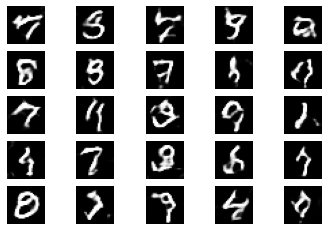

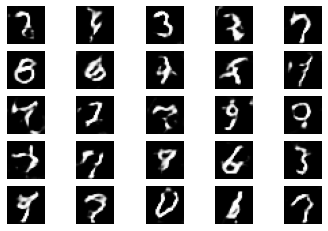

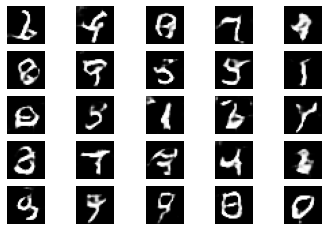

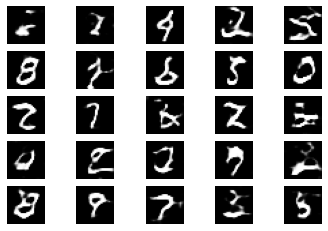

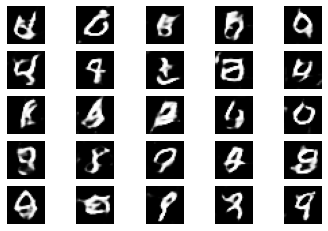

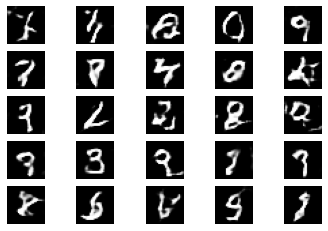

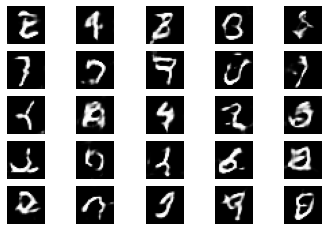

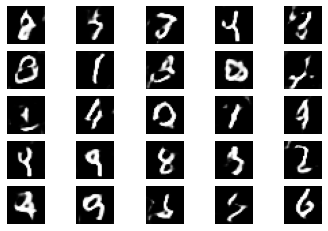

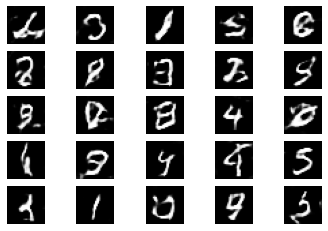

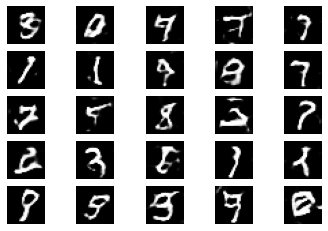

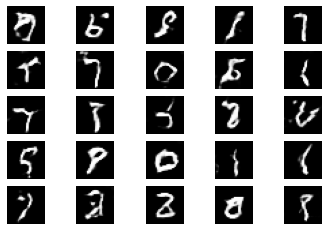

In [ ]:
# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

# MNIST 데이터 불러오기
    # 앞서 불러온 MNIST를 다시 이용합니다. 테스트 과정은 필요 없고
    # 이미지만 사용할 것이기 때문에 X_train만 호출합니다.
    (x_train, _), (_, _) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

    # 127.5를 뺀 후 127.5로 나누어서 -1~1 사이의 값으로 바꿉니다.
    x_train = (x_train - 127.5) / 127.5

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        # 실제 데이터를 판별자에 입력하는 부분입니다.
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # 가상 이미지를 판별자에 입력하는 부분입니다.
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        # 판별자와 생성자의 오차를 계산합니다.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 중간 과정을 이미지로 저장하는 부분입니다. 정해진 인터벌만큼 학습되면
        # 그때 만든 이미지를 gan_images 폴더에 저장하라는 의미입니다.
        # 이 코드는 이 장의 주된 목표와는 관계가 없어서 소스 코드만 소개합니다.
        if i % saving_interval == 0:
        # r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

         #Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("/content/data/gan_images/gan_mnist_%d.png" % i)

# 2000번 반복되고(+1을 하는 것에 주의),
# 배치 크기는 32, 200번마다 결과가 저장됩니다.
gan_train(2001, 32, 200)